In [1]:
import warnings
import numpy as np
import pandas as pd
from scipy import sparse as sp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3, linewidth=250)

### Loading Data set

In [3]:
x = np.loadtxt("../data/rin.dat")  #  data matrix

print("number of entities:", x.shape[0], ", number of features:", x.shape[1])

with open("../data/namrin", 'r') as fp:  # load names as list of string
    names_ = fp.readlines()

with open("../data/varrin", 'r') as fp:  # load features names as list of string
    features_ = fp.readlines()

number of entities: 91 , number of features: 5


### Creating Pandas DataFrame for Visualization


In [9]:
names = [name.strip() for name in names_]
features = [feature.strip().split(",")[0] for feature in features_]
# features

In [8]:
# df = pd.DataFrame(data=x, columns=features[:-1], index=names[1:])
# df.head()

#####  Nominal Features

There are 8 synthetic names of larger entities consisting of regions following after them. These names are as follows:

1:Central including Russia (20 entities altogether),

2: NW+South

3: Volga+Ural

4: Sibir+Far East

Four parts in total

In [10]:
# parts_names = ["'Central'", "'NW'", "'South'", "'Volga'", "'Ural'", "'Sibir'", "'FarEast'"]
parts_names = ["'Central'", "'NW'", "'Volga'", "'Sibir'", ]

In [11]:
parts_indices = [names.index(pn)-1 for pn in parts_names]
parts_indices

[0, 19, 47, 67]

### Categorizing the features
We consider the first and the last features, that is Internet abonents and Volume of information

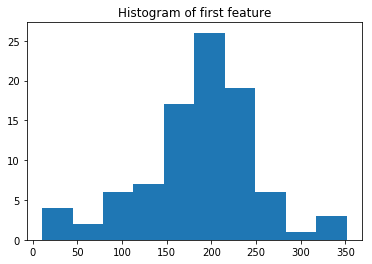

In [12]:
# number of bins is square root of number of entities in the data set
# range is (x.min(), x.max())
plt.hist(x[:, 0],int(np.round(np.sqrt(x.shape[0]))))
plt.title("Histogram of first feature")
plt.show()

boundaries for categorization of first feature : 

[0, 150, 200, 250, 350]


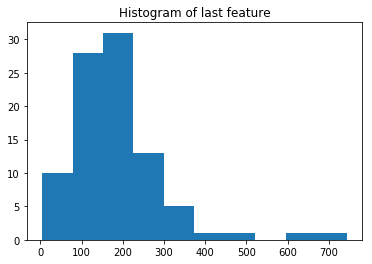

In [13]:
plt.hist(x[:, -1], bins=int(np.round(np.sqrt(x.shape[0]))))
plt.title("Histogram of last feature")
plt.show()

boundaries for categorization of last feature:

[0, 85, 250, 700]


### Part 1, Consider three nominal features 
one of them, not more, may be taken from nominal features in your data:

In [14]:
parts_indices

[0, 19, 47, 67]

In [15]:
# categorize version of x; the last columns for nominal feature
x_c = np.zeros([x.shape[0], x.shape[1]+1])

for i in range(x_c.shape[0]):
    for v in range(x_c.shape[1]):
        if v == 0:
            if 0 <= x[i, v] < 150:
                x_c[i, v] = 1
            elif 150 <= x[i, v] < 200:
                x_c[i, v] = 2
            elif 200 <= x[i, v] < 250:
                x_c[i, v] = 3
            else:
                x_c[i, v] = 4
        if v == 4:
            if 0 <= x[i, v] < 85:
                x_c[i, v] = 1
            elif 85 <= x[i, v] < 250:
                x_c[i, v] = 2
            else:
                x_c[i, v] = 3
        if v == 5:
            if 0 <= i <= parts_indices[1]:
                x_c[i,v] = 1
            elif parts_indices[1] < i <= parts_indices[2]:
                x_c[i,v] = 2
            elif parts_indices[2] < i <= parts_indices[3]:
                x_c[i,v] = 3
            else:
                x_c[i,v] = 4         
        elif v!= 0 and v!=4 and v!=5:
            x_c[i,v] = x[i,v]

# G, H, T
# x_categorical = x_c[:, [0, 4, 5]]  
print(x_c.shape)

(91, 6)


### Part 2: Contingency Tables

In [16]:
def contingency_matrix(subset_1, subset_2):
    
    """
    A faster way to create a contingency table.
    However this table is not intuitive
    """
    cat_1, cat_1_idx = np.unique(subset_1, return_inverse=True)
    cat_2, cat_2_idx = np.unique(subset_2, return_inverse=True)
    n_cat_1 = cat_1.shape[0]
    n_cat_2 = cat_2.shape[0]
    # sp.coo_matrix:= A sparse matrix in COOrdinate format.
    # Also known as the ‘ijv’ or ‘triplet’ format.
    contingency = sp.coo_matrix((np.ones(cat_1_idx.shape[0]),
                                (cat_1_idx, cat_2_idx)),
                                shape=(n_cat_1, n_cat_2),
                                dtype=np.int)
    
    contingency = contingency.toarray()
    
    return contingency
    

In [18]:
def contingency_table(subset_1, subset_2):
    
    """
    An slower way to create contingency table.
    But this way is more intuitive
    """
    
    cat_1, cat_1_idx = np.unique(subset_1, return_inverse=True)
    cat_2, cat_2_idx = np.unique(subset_2, return_inverse=True)
    n_cat_1 = cat_1.shape[0]
    n_cat_2 = cat_2.shape[0]
    contingency = np.zeros([n_cat_1, n_cat_2], dtype=np.int)
    for c_1 in range(n_cat_1):
        for c_2 in range(n_cat_2):
            contingency[c_1, c_2] = len(
                set(np.where(cat_1_idx==c_1)
                    [0].tolist()).intersection(
                    set(np.where(cat_2_idx==c_2)[0].tolist())))

    return contingency

#### Table G >> T

In [50]:
contingency_T_G = contingency_matrix(x_c[:, 5], x_c[:, 0])  # T given H
print("contingency T >> G:", "\n \n",
      contingency_T_G)

contingency T >> G: 
 
 [[ 1  7 10  2]
 [13  5  6  4]
 [ 0  5 13  2]
 [ 7 12  3  1]]


In [25]:
contingency_T_G_ = contingency_table(x_c[:, 5], x_c[:, 0]) # T given G
print("contingency T >> G:", "\n \n",
      contingency_T_G_)

contingency T >> G: 
 
 [[ 1  7 10  2]
 [13  5  6  4]
 [ 0  5 13  2]
 [ 7 12  3  1]]


- Rows:  T_1, ..., T_4 and
- Columns: G_1, ..., G_4

Identical results, however, let us use the faster way.

In [24]:
contingency_T_H = contingency_matrix(x_c[:, 5], x_c[:, 4])  # T given H
print("contingency T >> H:", "\n \n",
      contingency_T_H)

contingency T >> H: 
 
 [[ 0 17  3]
 [ 7 17  4]
 [ 0 19  1]
 [ 3 13  7]]


- Rows:  T_1, ..., T_4 and
- Columns: H_1, ..., H_3

#### Relative Frequenies 

In [52]:
relative_contingency_T_G = np.divide(contingency_T_G, x.shape[0])
print("Relative T G:", "\n \n", 
      relative_contingency_T_G)

print(" ")

relative_contingency_T_H = np.divide(contingency_T_H, x.shape[0])
print("Relative T H:", "\n \n", 
      relative_contingency_T_H)

Relative T G: 
 
 [[0.011 0.077 0.11  0.022]
 [0.143 0.055 0.066 0.044]
 [0.    0.055 0.143 0.022]
 [0.077 0.132 0.033 0.011]]
 
Relative T H: 
 
 [[0.    0.187 0.033]
 [0.077 0.187 0.044]
 [0.    0.209 0.011]
 [0.033 0.143 0.077]]


#### Conditional Probabilities

In [26]:
conditional_T_G = np.divide(contingency_T_G, np.sum(contingency_T_G, axis=0))
print("Conditional T give G:", "\n \n",
      conditional_T_G)

Conditional T give G: 
 
 [[0.048 0.241 0.312 0.222]
 [0.619 0.172 0.188 0.444]
 [0.    0.172 0.406 0.222]
 [0.333 0.414 0.094 0.111]]


 As one can see:

- Low conditional probability for T1 given G1.
- High conditional probability for T2 given G1.
- Zero conditional probability for T3 given G1.
- Low conditional probability for T4 given G3.
- The rest are not that informative


In [27]:
conditional_T_H = np.divide(contingency_T_H, np.sum(contingency_T_H, axis=0))
print("Conditional T give H:", "\n \n",
      conditional_T_H)

Conditional T give H: 
 
 [[0.    0.258 0.2  ]
 [0.7   0.258 0.267]
 [0.    0.288 0.067]
 [0.3   0.197 0.467]]


 As one can see:

- zero conditional probabilities for T1, T3 given H1.
- High conditional probability for T2 given H1.
- Low conditional probabilities for T3 given H3.
- The rest are not that informative

### Statistical independence

In [53]:
contingency_G_H = contingency_matrix(x_c[:, 0], x_c[:, 4])
relative_G_H = np.divide(contingency_G_H, x.shape[0])
for r in range(relative_G_H.shape[0]):
    print(relative_G_H[r, :], np.sum(relative_G_H[r, :]))
print(np.sum(relative_G_H, axis=0), np.sum(np.sum(relative_G_H, axis=1)))

[0.077 0.143 0.011] 0.23076923076923075
[0.033 0.253 0.033] 0.31868131868131866
[0.    0.297 0.055] 0.3516483516483516
[0.    0.033 0.066] 0.09890109890109891
[0.11  0.725 0.165] 0.9999999999999999


- Rows: G_1, ..., G_4, total G
- Columns: H_1, ..., H_3, total H